In [5]:
import requests
import json
import pandas as pd
import time
from datetime import datetime
key = os.getenv('OPEN_WEATHER_MAP_KEY')

def to_unix_time(dt):
    return int(time.mktime(dt.timetuple()))

def extract_current(lat, lon, key):
    getUrl = 'https://api.openweathermap.org/data/2.5/air_pollution'
    response = requests.get(getUrl, params={"lat": lat, "lon": lon, "appid": key})
    return json.loads(response.content.decode('utf-8'))

# def extract_forecast(lat, lon, key):
#     getUrl = 'https://api.openweathermap.org/data/2.5/air_pollution/forecast'
#     response = requests.get(getUrl, params={"lat": lat, "lon": lon, "appid": key})
#     return json.loads(response.content.decode('utf-8'))

def extract_history(lat, lon, start, end, key):
    getUrl = 'https://api.openweathermap.org/data/2.5/air_pollution/history'
    response = requests.get(getUrl, params={"lat": lat, "lon": lon, "start": start, "end": end, "appid": key})
    return json.loads(response.content.decode('utf-8'))

# Transform
def transform_response(response):
    # Assuming the response has data in a list of dictionaries format
    df = pd.DataFrame(response['list'])
    df['dt'] = pd.to_datetime(df['dt'], unit='s')
    # Additional transformation steps can be added here as needed
    # Extract the 'aqi' value from the 'main' dictionary
    df['aqi'] = df['main'].apply(lambda x: x['aqi'])
    # Normalize the 'components' column to create separate columns for each component
    components_df = pd.json_normalize(df['components'])
    # Concatenate the new columns to the original dataframe
    df = pd.concat([df, components_df], axis=1)
    # Drop the 'main' and 'components' columns as they are no longer needed
    df.drop(columns=['main', 'components'], inplace=True)
    return df

# The App in action: Run custom functions if valid inputs are entered

# Sample latitude and longitude for demonstration
# Start time: January 1, 2021
start_dt = datetime(2021, 1, 1)
start = to_unix_time(start_dt)

# End time: December 31, 2022, 23:59:59
end_dt = datetime(2022, 12, 31, 23, 59, 59)
end = to_unix_time(end_dt)

# response_current = extract_current(lat, lon, key)
# response_forecast = extract_forecast(lat, lon, key)
lat, lon = (48.8566, 2.3522)
response_history = extract_history(lat, lon, start, end, key)

# df_current = transform_response(response_current)
# df_forecast = transform_response(response_forecast)
df_history = transform_response(response_history)

# Example of displaying the dataframes
# display("Current Air Quality Data", df_current)
# display("Forecasted Air Quality Data", df_forecast)
display("Historical Air Quality Data", df_history)


KeyError: 'list'

In [2]:
import os
import json

from dotenv import load_dotenv
load_dotenv()



def extract_current(lat, lon, key):
    getUrl = 'https://api.openweathermap.org/data/2.5/air_pollution'
    response = requests.get(getUrl, params={"lat": lat, "lon": lon, "appid": openweathermap_key})
    response=json.loads(response.content.decode('utf-8'))
    df = pd.DataFrame(response['list'])
    return pd.json_normalize(df['components'])

extract_current(lat=48.8566, lon=2.3522, key=openweathermap_key)

KeyError: 'list'

In [21]:
components_df

,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,420.57,1.93,25.36,20.56,5.19,14.79,19.17,2.22


In [136]:
# Preprocessing

In [32]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd

def preprocess_data(df):
    # Normalize the pollutant columns (except 'aqi') using MinMaxScaler
    pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
    scaler = MinMaxScaler()
    for pollutant in pollutants:
        df[pollutant] = scaler.fit_transform(df[[pollutant]])  # No need to reshape as we are using DataFrame slicing

    # Extract 'year', 'month', 'day', 'hour', and 'weekday' from the 'dt' column
    # df['year'] = df['dt'].dt.year
    # df['month'] = df['dt'].dt.month
    # df['day'] = df['dt'].dt.day
    # df['hour'] = df['dt'].dt.hour
    # df['weekday'] = df['dt'].dt.day_name()  # Add the weekday names

    # Perform one-hot encoding using pd.get_dummies()
    # df = pd.get_dummies(df, columns=['year', 'month', 'day', 'hour', 'weekday'])

    return df

# Apply preprocessing to the DataFrame
df_history_preprocessed = preprocess_data(df_history)

# Display the preprocessed DataFrame
display("Preprocessed Historical Air Quality Data", df_history_preprocessed)


'Preprocessed Historical Air Quality Data'

,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,5,0.299097,0.240388,0.389582,0.000000,0.250735,0.251405,0.256694,0.243181
1,5,0.239900,0.190390,0.341361,0.000000,0.199525,0.202722,0.204570,0.212808
2,5,0.202013,0.155770,0.309252,0.000000,0.175277,0.171837,0.172292,0.197622
3,5,0.183070,0.136541,0.289155,0.000000,0.165838,0.156082,0.155869,0.190029
4,5,0.178334,0.132691,0.285112,0.000000,0.165838,0.153144,0.152480,0.195124
...,...,...,...,...,...,...,...,...,...
17323,1,0.012876,0.000011,0.075291,0.221142,0.013396,0.007942,0.009851,0.016485
17324,1,0.013763,0.000011,0.078280,0.221142,0.014583,0.008151,0.010059,0.017584
17325,1,0.012876,0.000011,0.068260,0.230776,0.013226,0.007605,0.009307,0.016985
17326,1,0.012283,0.000000,0.062225,0.233958,0.012209,0.007384,0.008947,0.016685


In [138]:
# Proportion of aqi
df_history_preprocessed.aqi.value_counts()


2    6470
1    6360
4    2005
3    1418
5    1075
Name: aqi, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Separation of training and test data sets
X = df_history_preprocessed.drop('aqi', axis=1)[["co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3"]]
y = df_history_preprocessed['aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training the random forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prediction on the test data set
y_pred = model.predict(X_test)

# Assessment with F1 score
score_f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' takes account of class imbalance
print(f"Score F1: {score_f1}")


Score F1: 0.9976891927751845


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculation of the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [56]:
df_history=pd.read_csv('data.csv', index_col=0)
df_history

,dt,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-12-31 23:00:00,5,3524.78,223.52,68.55,0.00,44.82,217.14,236.65,24.57
1,2021-01-01 00:00:00,5,2857.21,177.03,60.32,0.00,35.76,175.21,188.82,21.53
2,2021-01-01 01:00:00,5,2429.96,144.84,54.84,0.00,31.47,148.61,159.20,20.01
3,2021-01-01 02:00:00,5,2216.34,126.96,51.41,0.00,29.80,135.04,144.13,19.25
4,2021-01-01 03:00:00,5,2162.93,123.38,50.72,0.00,29.80,132.51,141.02,19.76
...,...,...,...,...,...,...,...,...,...,...
17323,2022-12-31 18:00:00,1,297.07,0.01,14.91,49.35,2.83,7.45,10.14,1.88
17324,2022-12-31 19:00:00,1,307.08,0.01,15.42,49.35,3.04,7.63,10.33,1.99
17325,2022-12-31 20:00:00,1,297.07,0.01,13.71,51.50,2.80,7.16,9.64,1.93
17326,2022-12-31 21:00:00,1,290.39,0.00,12.68,52.21,2.62,6.97,9.31,1.90


In [45]:
df_history_preprocessed = preprocess_data(df_history)
df_history_preprocessed

,Unnamed: 0,dt,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,0,2020-12-31 23:00:00,5,0.299097,0.240388,0.389582,0.000000,0.250735,0.251405,0.256694,0.243181
1,1,2021-01-01 00:00:00,5,0.239900,0.190390,0.341361,0.000000,0.199525,0.202722,0.204570,0.212808
2,2,2021-01-01 01:00:00,5,0.202013,0.155770,0.309252,0.000000,0.175277,0.171837,0.172292,0.197622
3,3,2021-01-01 02:00:00,5,0.183070,0.136541,0.289155,0.000000,0.165838,0.156082,0.155869,0.190029
4,4,2021-01-01 03:00:00,5,0.178334,0.132691,0.285112,0.000000,0.165838,0.153144,0.152480,0.195124
...,...,...,...,...,...,...,...,...,...,...,...
17323,17323,2022-12-31 18:00:00,1,0.012876,0.000011,0.075291,0.221142,0.013396,0.007942,0.009851,0.016485
17324,17324,2022-12-31 19:00:00,1,0.013763,0.000011,0.078280,0.221142,0.014583,0.008151,0.010059,0.017584
17325,17325,2022-12-31 20:00:00,1,0.012876,0.000011,0.068260,0.230776,0.013226,0.007605,0.009307,0.016985
17326,17326,2022-12-31 21:00:00,1,0.012283,0.000000,0.062225,0.233958,0.012209,0.007384,0.008947,0.016685


In [40]:
def preprocess_data(df, scaler):
    # Normalize the pollutant columns (except 'aqi') using MinMaxScaler
    pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
    scaler = MinMaxScaler()
    for pollutant in pollutants:
        df[pollutant] = scaler.fit_transform(df[[pollutant]])  # No need to reshape as we are using DataFrame slicing

    return df

In [57]:
data={
        "co": [3524.78],
        "no": [223.52],
        "no2": [68.55],
        "o3": [0.00],
        "so2": [44.82],
        "pm2_5": [217.14],
        "pm10": [236.65],
        "nh3": [24.57]
}

df_feature=pd.DataFrame(data)
df_feature

,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,3524.78,223.52,68.55,0.0,44.82,217.14,236.65,24.57


In [58]:
df=preprocess_data(df_feature)
df

,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# Séparation en jeu de données d'entraînement et de test
X = df_history_preprocessed.drop('aqi', axis=1)[["co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3"]]
y = df_history_preprocessed['aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entraînement du modèle SVM
model = SVC(random_state=42)
model.fit(X_train, y_train)

# Prédiction sur le jeu de données de test
y_pred = model.predict(X_test)

# Évaluation avec le score F1
score_f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' prend en compte le déséquilibre des classes
print(f"Score F1: {score_f1}")


Score F1: 0.9150298774029348


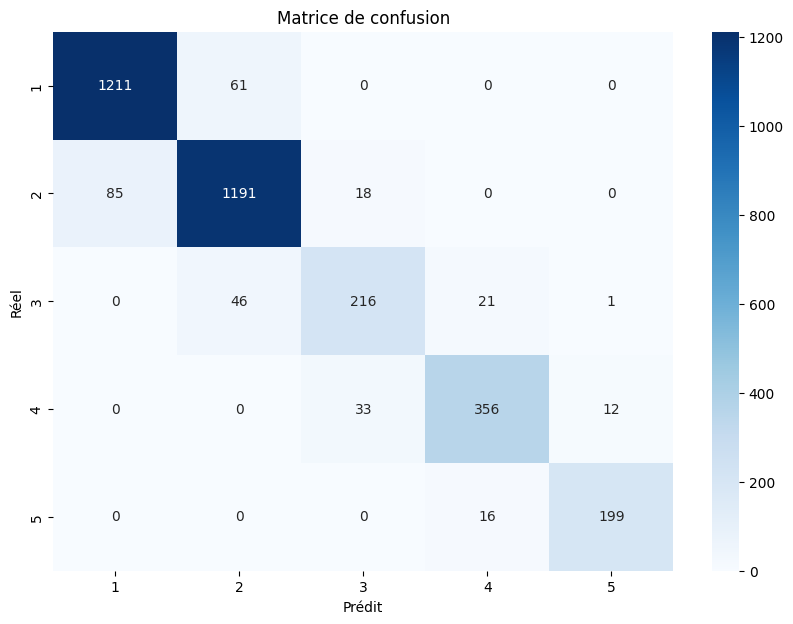

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculation of the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()
